In [1]:
%run utils.py

C:\Development\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

### Data Acquisition

#### South African Heart Disease Dataset

https://web.stanford.edu/~hastie/ElemStatLearn/data.html

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

In [3]:
columns = [
    'Patient ID',
    'Systolic Blood Pressure', 
    'Tobacco (kg)', 
    'LDL', 
    'Adiposity', 
    'Fam. Hist', 
    'Type A', 
    'Obesity', 
    'Alcohol', 
    'Age',
    'Coronary Heart Disease'
]

In [4]:
heart_disease_data = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data')
heart_disease_data.columns = columns

In [5]:
f1 = 'Age'
f2 = 'Systolic Blood Pressure'
id = 'Patient ID'
target = 'Coronary Heart Disease'

Take a sample of 100 instances to form the training dataset

In [6]:
data = heart_disease_data.sample(100, random_state=43)[[id, f1, f2, target]]
data[target] = data[target].apply(lambda x: False if not x else True)

In [7]:
data.sort_values(f2)

,Patient ID,Age,Systolic Blood Pressure,Coronary Heart Disease
20,21,20,106,True
179,180,56,108,False
440,442,32,110,False
166,167,55,110,True
67,68,27,112,False
...,...,...,...,...
229,230,50,188,True
314,316,50,190,False
407,409,60,200,True
403,405,58,208,True


## Data Preparation

### Cleansing

Introduce erronous value

In [8]:
data_noise = data.copy()
data_noise.loc[103, 'Age'] *= 365

In [9]:
data_noise.describe()

,Patient ID,Age,Systolic Blood Pressure
count,100.00,100.00,100.00
mean,245.48,157.54,140.65
std,136.16,"1,127.12",22.27
min,13.00,16.00,106.00
25%,127.50,32.00,124.00
50%,253.50,49.50,136.00
75%,362.50,58.25,154.00
max,459.00,"11,315.00",214.00


Some utilty functions to plot the data distribution

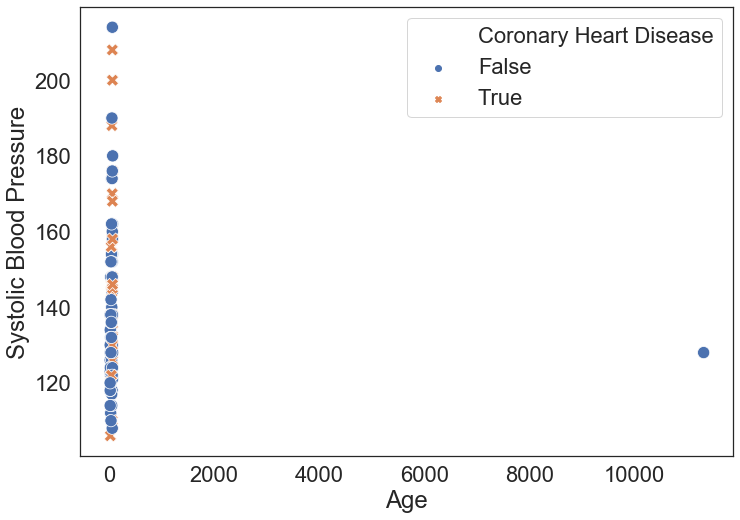

In [10]:
plot_data_and_decision_boundary(data_noise, f1, f2, target)

In [11]:
data_noise[data_noise.Age > 10000]

,Patient ID,Age,Systolic Blood Pressure,Coronary Heart Disease
103,104,11315,128,False


Print the dataframe with features and binary target variables

In [12]:
data_display = data.copy()
data_display[target] = data_display[target].astype(int)
data_display.sort_values(id)

,Patient ID,Age,Systolic Blood Pressure,Coronary Heart Disease
12,13,17,118,0
15,16,46,117,0
17,18,53,146,1
18,19,62,158,1
20,21,20,106,1
...,...,...,...,...
448,450,20,124,0
449,451,48,144,1
452,454,42,154,0
453,455,51,124,1


Plot the clean dataset

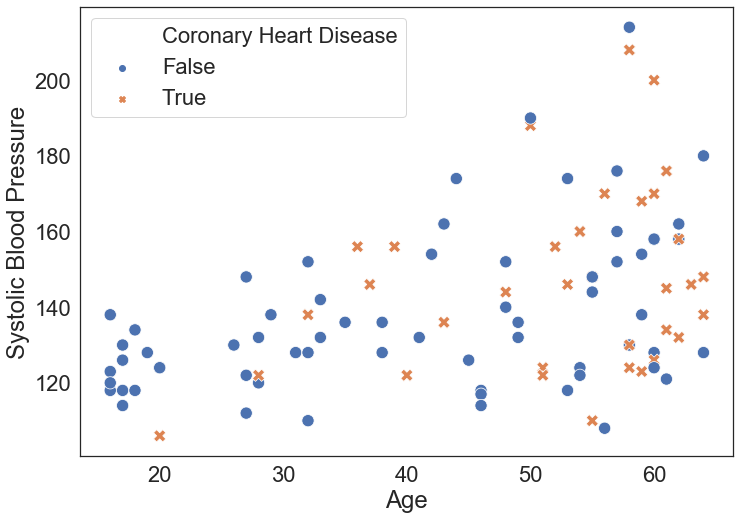

In [13]:
plot_data_and_decision_boundary(data, f1, f2, target)

## Predictive Modelling

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score

def eval(model, X, y):
    pred = model.predict(X)
    print(confusion_matrix(y, pred))
    print('Accuracy: %.2f' % accuracy_score(y, pred))
    print('Precision: %.2f' % precision_score(y, pred))
    print('Recall: %.2f' % recall_score(y, pred))
    print('AUC: %.2f' % roc_auc_score(y, pred))

Train a simple Logistic Regression model

In [16]:
linear_model = LogisticRegression(solver='lbfgs')

X = data[[f1, f2]]
y = data[target]
linear_model.fit(X, y)

LogisticRegression()

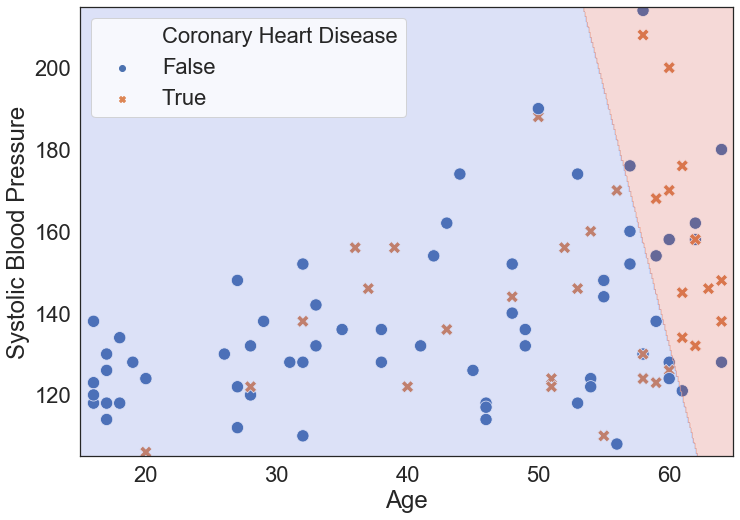

In [17]:
plot_data_and_decision_boundary(data, f1, f2, target, linear_model)

In [18]:
linear_model.coef_

array([[0.05469812, 0.00435669]])

In [19]:
linear_model.intercept_

array([-3.85732665])

In [20]:
def logit(v): return 1 / (1 + np.exp(-v))

In [21]:
logit(linear_model.coef_.dot(np.array([62, 158])) + linear_model.intercept_)

array([0.55535078])

Get a different decision boundary by adjusting the weight of each class

In [22]:
weighted_linear_model = LogisticRegression(solver='lbfgs', class_weight={0: 0.5, 1: 1}, C=10.0, fit_intercept=False)

weighted_linear_model.fit(X, y)

LogisticRegression(C=10.0, class_weight={0: 0.5, 1: 1}, fit_intercept=False)

In [23]:
weighted_linear_model.coef_

array([[ 0.04885209, -0.01527888]])

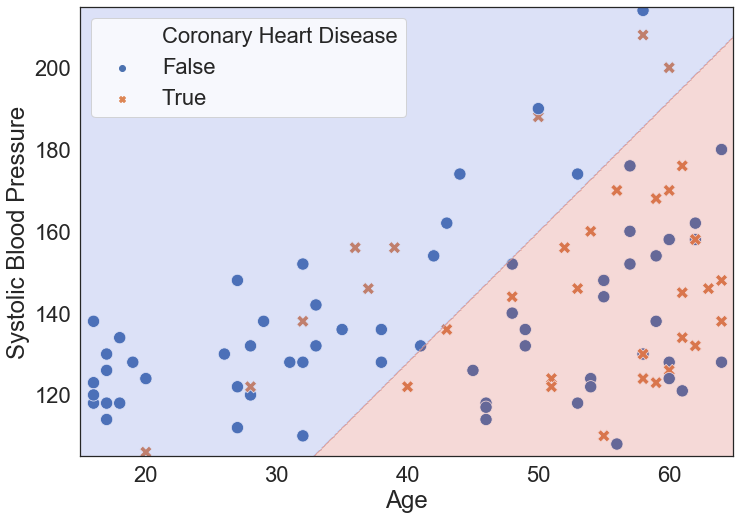

In [24]:
plot_data_and_decision_boundary(data, f1, f2, target, weighted_linear_model)

Train a model with polynomial feature interactions (see feature engineering)

In [25]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)), ('logreg', LogisticRegression(solver='lbfgs'))])

X = data[[f1, f2]]
y = data[target]
poly_model.fit(X, y)

Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('logreg', LogisticRegression())])

In [26]:
poly_model['logreg'].coef_

array([[-0.01540401, -0.02487311,  0.00052915]])

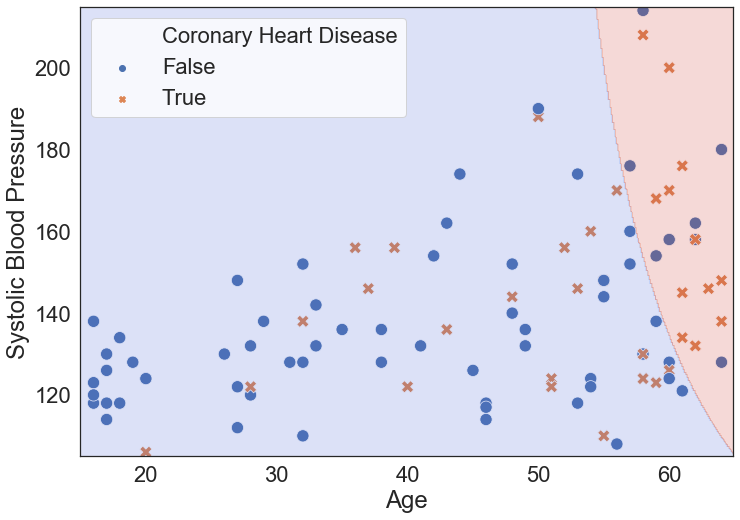

In [27]:
plot_data_and_decision_boundary(data, f1, f2, target, poly_model)

Train a non-linear support vector machine with poorly chosen hyperparameters

In [28]:
from sklearn.svm import SVC

In [29]:
svm_model = SVC(C=1., gamma=0.1)
svm_model.fit(X, y)

SVC(gamma=0.1)

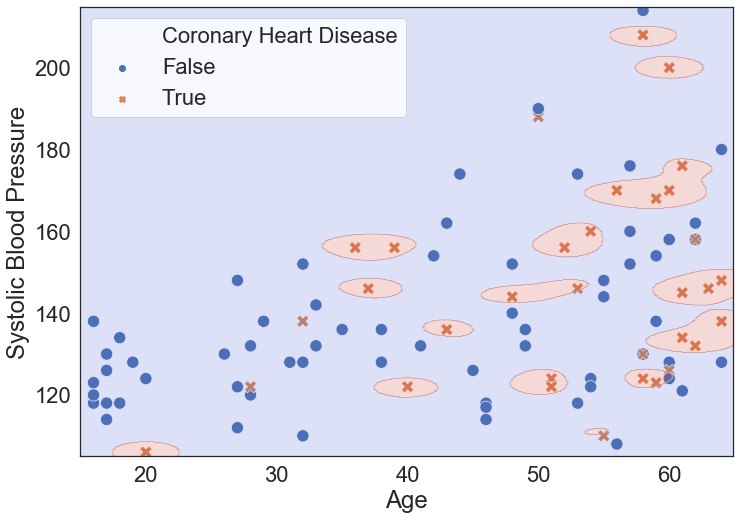

In [30]:
plot_data_and_decision_boundary(data, f1, f2, target, svm_model)

## Evaluation

Sample a non-overlapping test set

In [31]:
test_data = heart_disease_data.drop(data.index).sample(100, random_state=2)

X_test = test_data[[f1, f2]]
y_test = test_data[target]

Linear model

In [32]:
eval(linear_model, X, y)

[[56 10]
 [22 12]]
Accuracy: 0.68
Precision: 0.55
Recall: 0.35
AUC: 0.60


In [33]:
eval(linear_model, X_test, y_test)

[[56  8]
 [25 11]]
Accuracy: 0.67
Precision: 0.58
Recall: 0.31
AUC: 0.59


Weighted model puts more emphasis on positive samples, so recall is higher for the cost of lower precision

In [34]:
eval(weighted_linear_model, X, y)

[[37 29]
 [ 9 25]]
Accuracy: 0.62
Precision: 0.46
Recall: 0.74
AUC: 0.65


In [35]:
eval(weighted_linear_model, X_test, y_test)

[[38 26]
 [10 26]]
Accuracy: 0.64
Precision: 0.50
Recall: 0.72
AUC: 0.66


Simple polynomial model is able to fit the data slightly better than linear model

In [36]:
eval(poly_model, X, y)

[[57  9]
 [22 12]]
Accuracy: 0.69
Precision: 0.57
Recall: 0.35
AUC: 0.61


In [37]:
eval(poly_model, X_test, y_test)

[[57  7]
 [25 11]]
Accuracy: 0.68
Precision: 0.61
Recall: 0.31
AUC: 0.60


Complex Non-linear model has good accuracy on training set, but overfits

In [38]:
eval(svm_model, X, y)

[[65  1]
 [ 8 26]]
Accuracy: 0.91
Precision: 0.96
Recall: 0.76
AUC: 0.87


In [39]:
eval(svm_model, X_test, y_test)

[[60  4]
 [30  6]]
Accuracy: 0.66
Precision: 0.60
Recall: 0.17
AUC: 0.55
